In [1]:
import numpy as np
import pandas as pd
import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# Loading driving log into pandas
driving_data = pd.read_csv("/input/driving_log.csv", header=None)

In [3]:
# Assigning the center, left and right image paths + steering angles to variables
center_cam_path = driving_data[0]
left_cam_path = driving_data[1]
right_cam_path = driving_data[2]
steering_angle = driving_data[3]

In [4]:
images = []
measurements = []
# Randomly choosing cam image
for i in range(0, len(steering_angle)):
    cam = np.random.choice(["center", "left", "right"])

    if cam == "left":
        image = cv2.imread("/input/"+left_cam_path[i].lstrip())
        steering_angle_left = steering_angle[i] + 0.20
        images.append(image)
        measurements.append(steering_angle_left)
    elif cam == "right":
        image = cv2.imread("/input/"+right_cam_path[i].lstrip())
        steering_angle_right = steering_angle[i] - 0.20
        images.append(image)
        measurements.append(steering_angle_right)
    else:
        image = cv2.imread("/input/"+center_cam_path[i].lstrip())
        steering_angle_center = steering_angle[i]
        images.append(image)
        measurements.append(steering_angle_center)

In [5]:
def flip_image(img):
    image_flip = cv2.flip(img, 1)
    return image_flip

In [6]:
def augment_brightness(img):
    image1 = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

In [7]:
# Translation
def trans_image(img, steering_angle, trans_range):
    height, width, ch = img.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_angle = steering_angle + tr_x/trans_range*2*.2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    trans_M = np.float32([[1,0,tr_x], [0,1,tr_y]])
    img1 = cv2.warpAffine(img,trans_M,(width, height))
    return img1, steer_angle

In [8]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(flip_image(image))
    augmented_measurements.append(measurement * -1.0)
    augmented_images.append(augment_brightness(image))
    augmented_measurements.append(measurement)
    img, angle = trans_image(image, measurement, 100)
    augmented_images.append(img)
    augmented_measurements.append(angle)

In [9]:
len(augmented_images)

32144

In [10]:
len(augmented_measurements)

32144

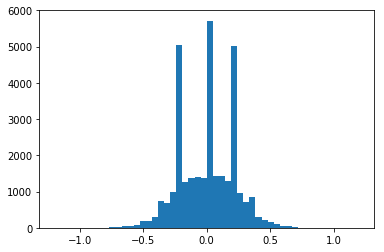

In [11]:
plt.hist(augmented_measurements, bins=50)
plt.show()

In [12]:
augmented_images = np.array(augmented_images)
augmented_measurements = np.array(augmented_measurements)

mask = np.logical_and(
    np.random.rand() < 0.70,
    np.isclose(np.abs(augmented_measurements), 0.20)
)

filtered_measurements = augmented_measurements[~mask]
filtered_images = augmented_images[~mask]

In [13]:
len(filtered_images)

23582

In [14]:
len(filtered_measurements)

23582

In [18]:
filtered_images = np.array(filtered_images)
filtered_measurements = np.array(filtered_measurements)

mask = np.logical_and(
    np.random.rand() < 0.85,
    np.isclose(np.abs(filtered_measurements), 0.0)
)

new_filtered_measurements = filtered_measurements[~mask]
new_filtered_images = filtered_images[~mask]

In [19]:
len(new_filtered_images)

19061

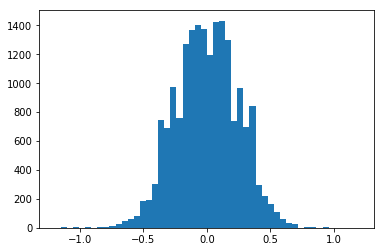

In [20]:
plt.hist(new_filtered_measurements, bins=50)
plt.show()

In [21]:
aug_images_rgb = []
    
for image in new_filtered_images:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    aug_images_rgb.append(image_rgb)

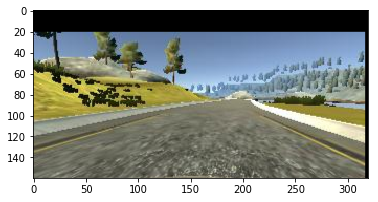

In [22]:
plt.imshow(aug_images_rgb[np.random.randint(1, len(aug_images_rgb))])
plt.show()

In [23]:
X_train = np.array(aug_images_rgb)
y_train = np.array(new_filtered_measurements)

In [24]:
# Model
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dense(1))

In [25]:
model.compile(loss = "mse", optimizer = Adam(lr=0.0001))
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)
model.save("model_nvidia13.h5")

Train on 15248 samples, validate on 3813 samples
Epoch 1/5
15248/15248 [==============================] - 21s - loss: 0.0345 - val_loss: 0.0257